In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import moire_lattice_py as ml
import math
from typing import List, Tuple, Dict

# Import meep for band calculations
try:
    import meep as mp
    from meep import mpb
    MEEP_AVAILABLE = True
    print("✓ Meep is available for band structure calculations")
except ImportError:
    MEEP_AVAILABLE = False
    print("✗ Meep not available - will only visualize structure")

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2

# Physical parameters for graphene
CARBON_CARBON_DIST = 1.42  # Angstroms - C-C bond length in graphene
LATTICE_CONSTANT = CARBON_CARBON_DIST * np.sqrt(3)  # ~2.46 Angstroms
MAGIC_ANGLE = 1.1 * np.pi / 180  # 1.1 degrees in radians (not magic right now)

print(f"Graphene parameters:")
print(f"  C-C bond length: {CARBON_CARBON_DIST:.3f} Å")
print(f"  Lattice constant: {LATTICE_CONSTANT:.3f} Å")
print(f"  Magic angle: {MAGIC_ANGLE * 180 / np.pi:.2f}°")

✓ Meep is available for band structure calculations
Graphene parameters:
  C-C bond length: 1.420 Å
  Lattice constant: 2.460 Å
  Magic angle: 1.10°


## 1. Create Hexagonal Lattice and Define Honeycomb Motif

In [2]:
# Create the base hexagonal lattice
hex_lattice = ml.create_hexagonal_lattice(1.0)  # Normalized units

# Get lattice vectors
a1, a2 = hex_lattice.lattice_vectors()
print(f"Lattice vectors (normalized):")
print(f"  a1 = [{a1[0]:.4f}, {a1[1]:.4f}]")
print(f"  a2 = [{a2[0]:.4f}, {a2[1]:.4f}]")

# Define the honeycomb motif in fractional coordinates
# Graphene has two carbon atoms per unit cell
motif_positions_frac = [
    (0.0, 0.0, 0.0),      # Atom A at origin
    (1/3, 2/3, 0.0)       # Atom B at (1/3)a1 + (2/3)a2
]

# Convert to Cartesian coordinates
def frac_to_cart(frac_coords, a1, a2):
    """Convert fractional to Cartesian coordinates for 2D lattice"""
    x = frac_coords[0] * a1[0] + frac_coords[1] * a2[0]
    y = frac_coords[0] * a1[1] + frac_coords[1] * a2[1]
    return (x, y, 0.0)

motif_positions_cart = [frac_to_cart(pos, a1, a2) for pos in motif_positions_frac]

print(f"\nHoneycomb motif positions:")
print(f"  Atom A (frac): {motif_positions_frac[0]} → (cart): ({motif_positions_cart[0][0]:.4f}, {motif_positions_cart[0][1]:.4f})")
print(f"  Atom B (frac): {motif_positions_frac[1]} → (cart): ({motif_positions_cart[1][0]:.4f}, {motif_positions_cart[1][1]:.4f})")

# Verify nearest neighbor distance
nn_dist = np.linalg.norm(np.array(motif_positions_cart[1][:2]) - np.array(motif_positions_cart[0][:2]))
print(f"\nNearest neighbor distance: {nn_dist:.4f} (should be {1/np.sqrt(3):.4f} for unit lattice constant)")

Lattice vectors (normalized):
  a1 = [1.0000, 0.0000]
  a2 = [-0.5000, 0.8660]

Honeycomb motif positions:
  Atom A (frac): (0.0, 0.0, 0.0) → (cart): (0.0000, 0.0000)
  Atom B (frac): (0.3333333333333333, 0.6666666666666666, 0.0) → (cart): (0.0000, 0.5774)

Nearest neighbor distance: 0.5774 (should be 0.5774 for unit lattice constant)


## 2. Create Twisted Bilayer Moiré Pattern

In [3]:
# Create the moiré pattern using the builder
print(f"Creating moiré pattern with twist angle θ = {MAGIC_ANGLE * 180 / np.pi:.2f}°")

builder = ml.PyMoireBuilder()
builder.with_base_lattice(hex_lattice)
builder.with_twist_and_scale(MAGIC_ANGLE, 1.0)  # Pure rotation, no scaling

moire = builder.build()

# Get moiré properties
print(f"\nMoiré lattice properties:")
print(f"  Twist angle: {moire.twist_angle_degrees():.2f}°")
print(f"  Moiré period ratio: {moire.moire_period_ratio():.1f}")
print(f"  Is commensurate: {moire.is_commensurate()}")
print(f"  Moiré unit cell area: {moire.cell_area():.2f} (in units of original cell)")

# Get the constituent lattices
lattice_1 = moire.lattice_1()  # Bottom layer (unrotated)
lattice_2 = moire.lattice_2()  # Top layer (rotated)

# Get moiré lattice vectors
moire_lattice = moire.as_lattice2d()
m1, m2 = moire_lattice.lattice_vectors()
print(f"\nMoiré lattice vectors:")
print(f"  m1 = [{m1[0]:.4f}, {m1[1]:.4f}]")
print(f"  m2 = [{m2[0]:.4f}, {m2[1]:.4f}]")
print(f"  |m1| = {np.linalg.norm(m1):.2f}, |m2| = {np.linalg.norm(m2):.2f}")

Creating moiré pattern with twist angle θ = 1.10°

Moiré lattice properties:
  Twist angle: 1.10°
  Moiré period ratio: 52.1
  Is commensurate: False
  Moiré unit cell area: 2349.65 (in units of original cell)

Moiré lattice vectors:
  m1 = [-0.5000, 52.0855]
  m2 = [-44.8573, -26.4757]
  |m1| = 52.09, |m2| = 52.09


## 3. Build Complete Moiré Supercell Geometry

The crucial step: find all atoms from both layers that fall within the moiré unit cell. This involves:
1. Generating lattice points from both layers in a large enough region
2. Applying the motif to each lattice point
3. Checking which atoms fall inside the moiré unit cell
4. Collecting all atoms for the supercell

In [4]:
def get_atoms_in_moire_cell(layer_lattice, motif_frac, moire_vectors, search_radius_factor=3.0):
    """
    Find all atoms from a layer that fall within the moiré unit cell.
    
    Args:
        layer_lattice: The Lattice2D for this layer
        motif_frac: List of fractional coordinates for the motif
        moire_vectors: Tuple of moiré lattice vectors (m1, m2)
        search_radius_factor: How many moiré periods to search
        
    Returns:
        List of (x, y, atom_type) tuples for atoms in the moiré cell
    """
    m1, m2 = moire_vectors
    layer_a1, layer_a2 = layer_lattice.lattice_vectors()
    
    # Determine search radius based on moiré cell size
    moire_cell_size = max(np.linalg.norm(m1), np.linalg.norm(m2))
    search_radius = search_radius_factor * moire_cell_size
    
    # Generate lattice points in the search region
    lattice_points = layer_lattice.generate_points(search_radius)
    
    atoms_in_cell = []
    
    # For each lattice point, place the motif
    for lat_point in lattice_points:
        for i, motif_pos in enumerate(motif_frac):
            # Calculate atom position
            atom_x = lat_point[0] + motif_pos[0] * layer_a1[0] + motif_pos[1] * layer_a2[0]
            atom_y = lat_point[1] + motif_pos[0] * layer_a1[1] + motif_pos[1] * layer_a2[1]
            
            # Check if atom is inside moiré unit cell
            # Express position in moiré fractional coordinates
            # Solve: (atom_x, atom_y) = s * m1 + t * m2
            mat = np.array([[m1[0], m2[0]], [m1[1], m2[1]]])
            try:
                frac = np.linalg.solve(mat, np.array([atom_x, atom_y]))
                
                # Check if inside unit cell (0 <= s, t < 1)
                if 0 <= frac[0] < 1.0 and 0 <= frac[1] < 1.0:
                    atom_type = 'A' if i == 0 else 'B'
                    atoms_in_cell.append((atom_x, atom_y, atom_type))
            except np.linalg.LinAlgError:
                # Singular matrix, skip this point
                continue
    
    return atoms_in_cell

# Get atoms from both layers
print("Finding atoms in moiré unit cell...")
atoms_layer_1 = get_atoms_in_moire_cell(lattice_1, motif_positions_frac, (m1, m2))
atoms_layer_2 = get_atoms_in_moire_cell(lattice_2, motif_positions_frac, (m1, m2))

print(f"\nAtoms found in moiré unit cell:")
print(f"  Layer 1: {len(atoms_layer_1)} atoms")
print(f"    - Type A: {sum(1 for a in atoms_layer_1 if a[2] == 'A')}")
print(f"    - Type B: {sum(1 for a in atoms_layer_1 if a[2] == 'B')}")
print(f"  Layer 2: {len(atoms_layer_2)} atoms")
print(f"    - Type A: {sum(1 for a in atoms_layer_2 if a[2] == 'A')}")
print(f"    - Type B: {sum(1 for a in atoms_layer_2 if a[2] == 'B')}")
print(f"  Total: {len(atoms_layer_1) + len(atoms_layer_2)} atoms")

# Expected number of atoms per moiré cell
expected_atoms = 2 * 2 * moire.moire_period_ratio()**2  # 2 atoms/cell × 2 layers × area ratio
print(f"\nExpected atoms (approximate): {expected_atoms:.0f}")

Finding atoms in moiré unit cell...

Atoms found in moiré unit cell:
  Layer 1: 5426 atoms
    - Type A: 2712
    - Type B: 2714
  Layer 2: 5425 atoms
    - Type A: 2712
    - Type B: 2713
  Total: 10851 atoms

Expected atoms (approximate): 10853


## 4. Visualize the Moiré Structure

Let's create detailed visualizations to verify our atom placement is correct. We'll show:
1. Individual layers with their motifs
2. The complete moiré supercell
3. Local stacking patterns (AA, AB, BA regions)

Creating visualization (this may take a moment for large supercells)...
Total atoms: Layer 1: 5426, Layer 2: 5425


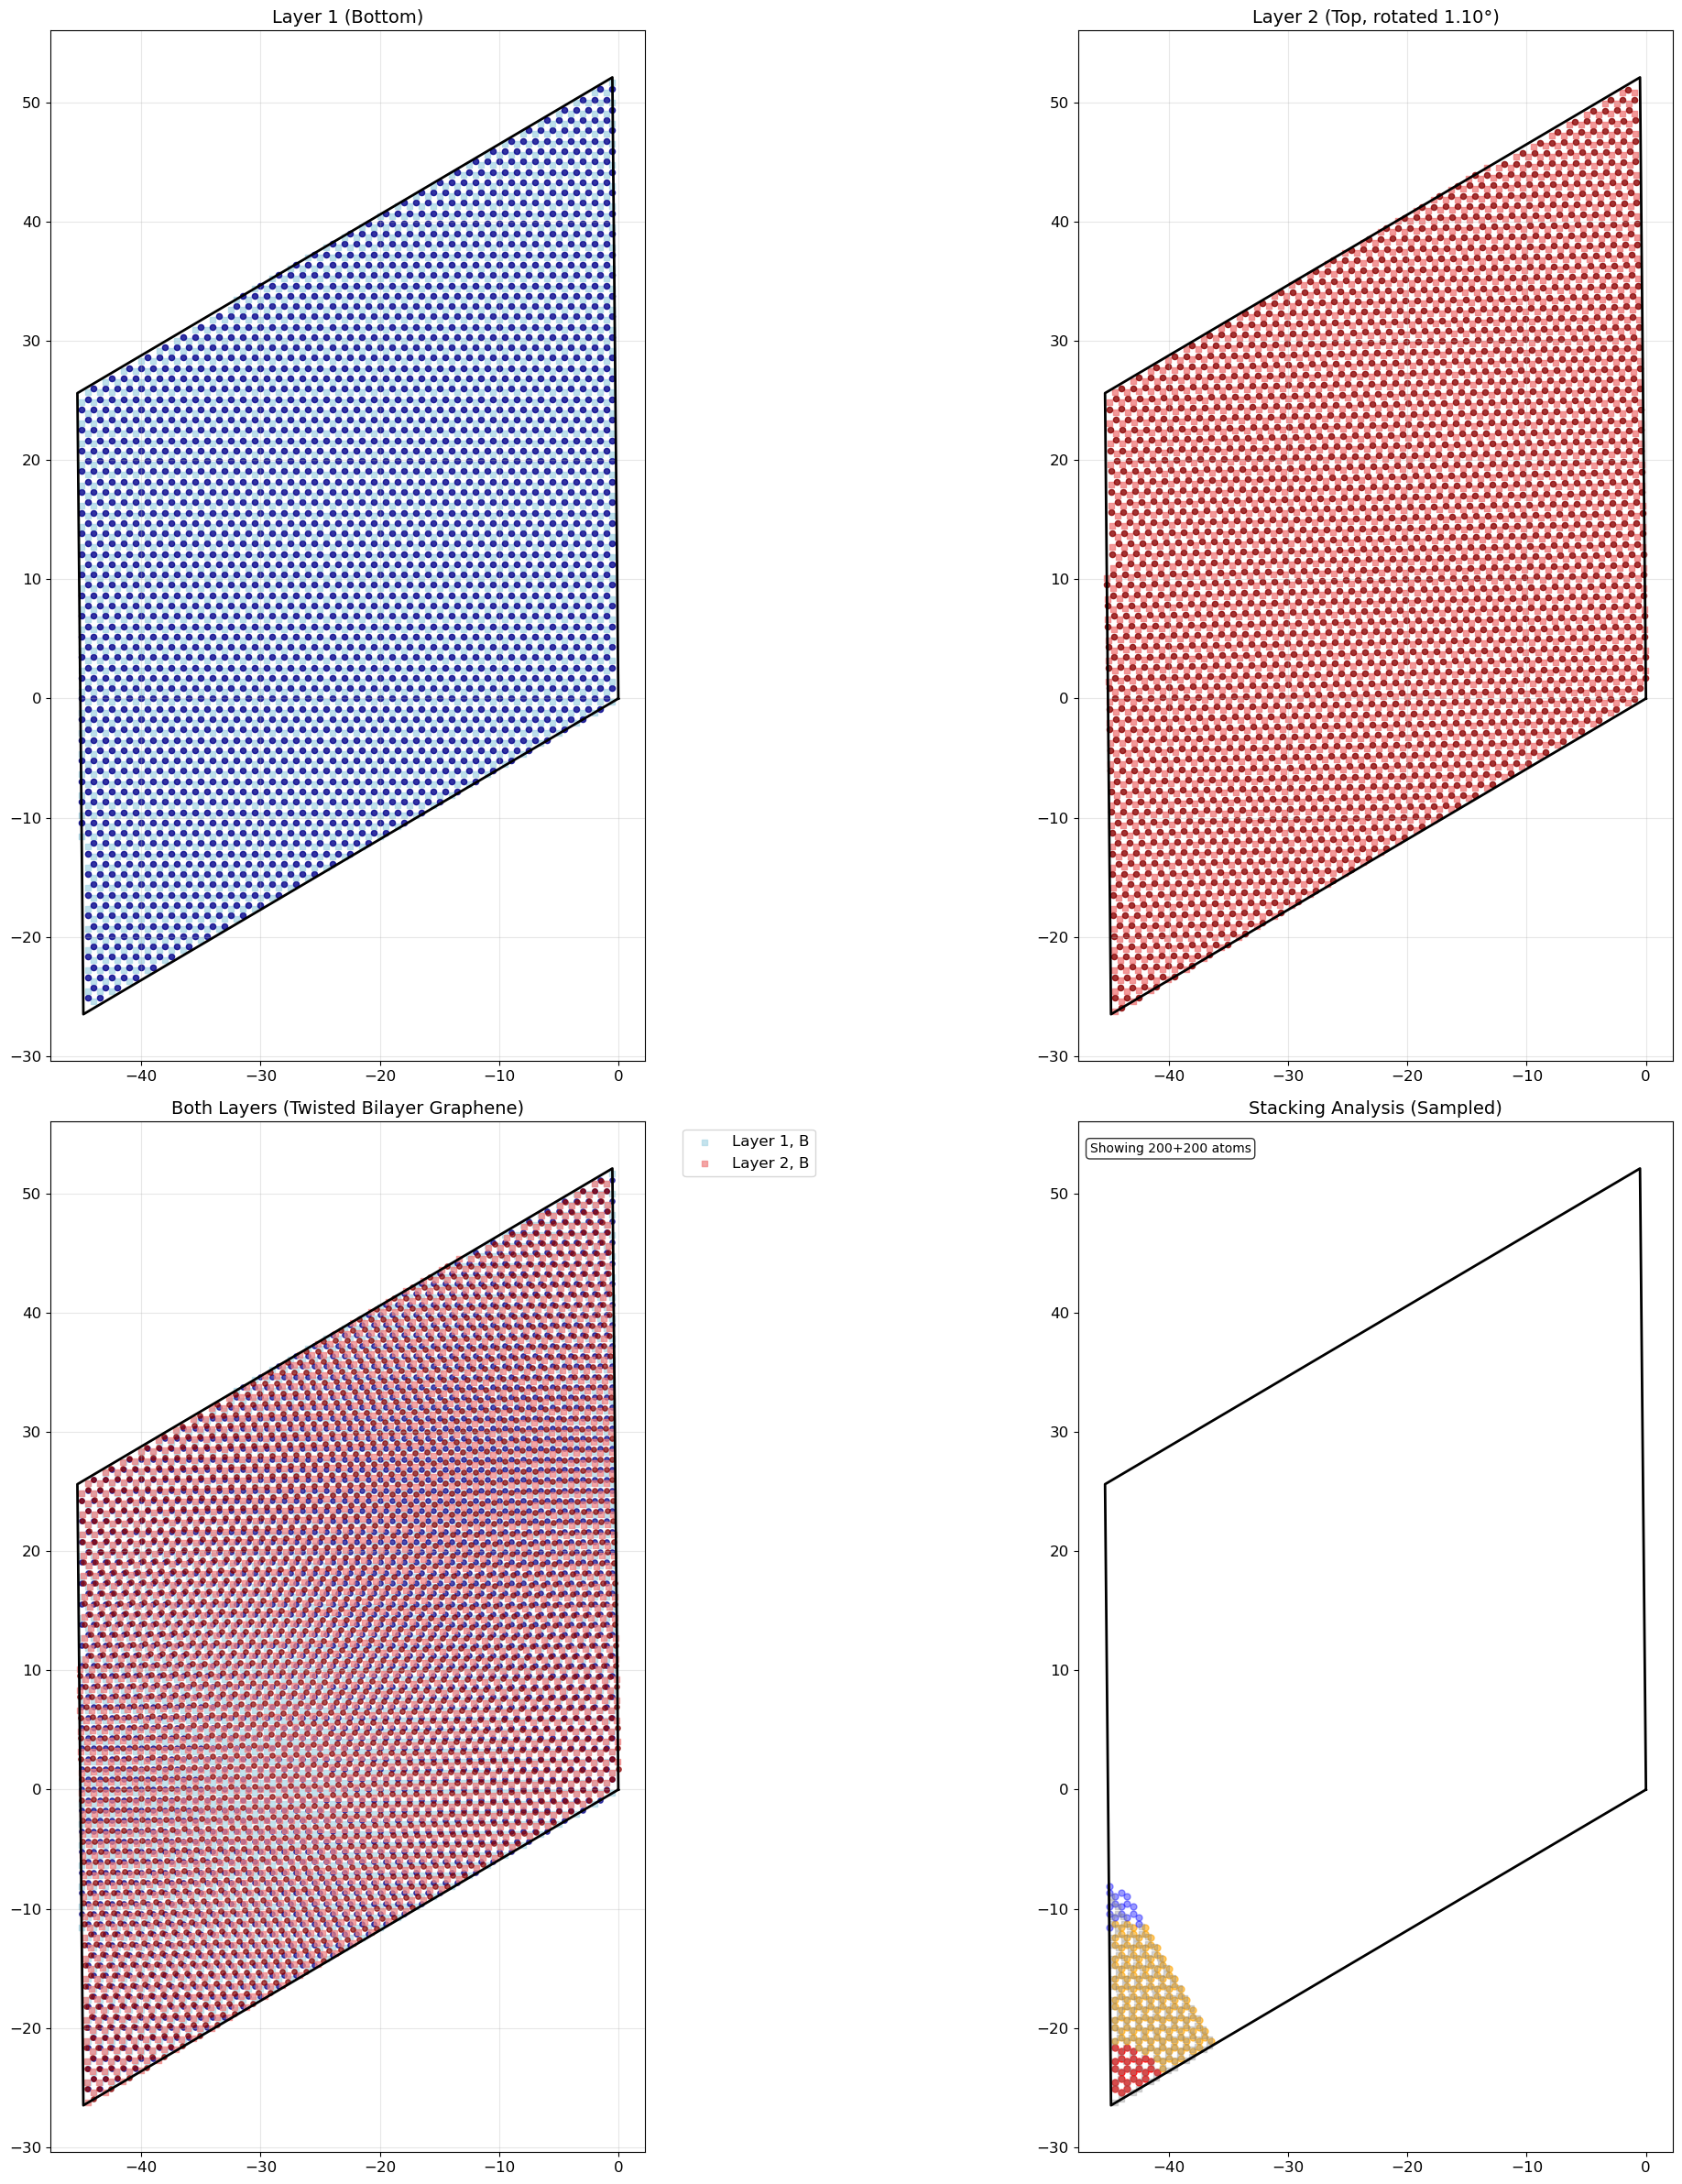

Creating zoomed view...


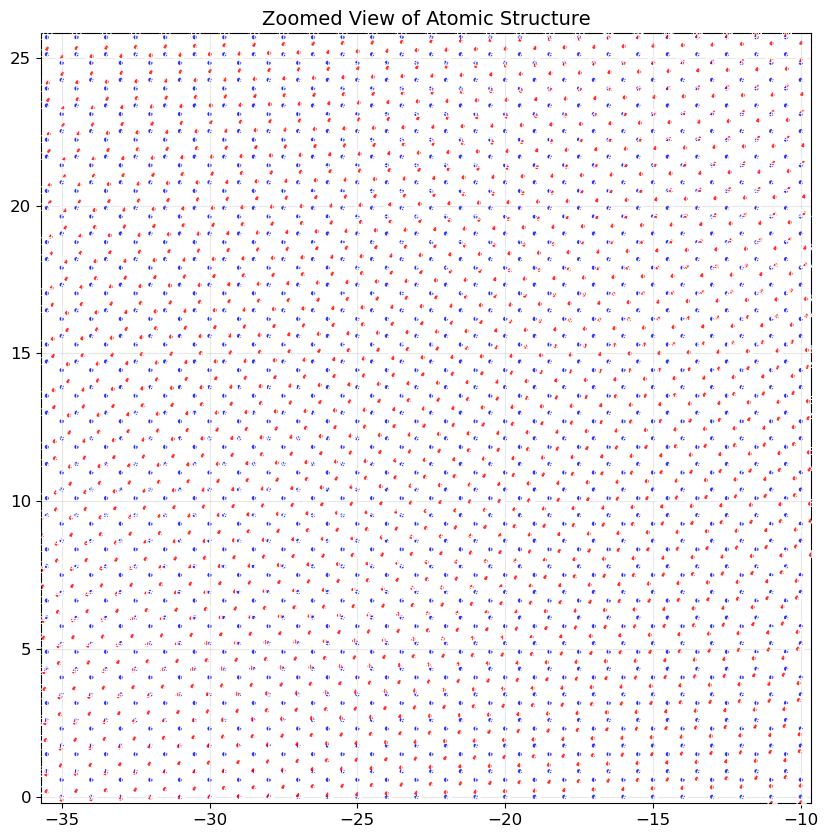

In [5]:
def plot_moire_structure(atoms_l1, atoms_l2, m1, m2, title="Moiré Structure"):
    """Create a detailed plot of the moiré structure"""
    
    fig, axes = plt.subplots(2, 2, figsize=(24, 24))
    
    # Define colors for different atom types and layers
    colors = {
        ('A', 1): 'darkblue',
        ('B', 1): 'lightblue',
        ('A', 2): 'darkred',
        ('B', 2): 'lightcoral'
    }
    
    # Convert moiré vectors to numpy arrays for proper slicing
    m1_arr = np.array(m1)
    m2_arr = np.array(m2)
    
    # Plot 1: Layer 1 only
    ax = axes[0, 0]
    for x, y, atype in atoms_l1:
        ax.scatter(x, y, c=colors[(atype, 1)], s=20, alpha=0.8, 
                  marker='o' if atype == 'A' else 's')
    
    # Draw moiré unit cell
    cell_corners = np.array([[0, 0], m1_arr[:2], m1_arr[:2] + m2_arr[:2], m2_arr[:2], [0, 0]])
    ax.plot(cell_corners[:, 0], cell_corners[:, 1], 'k-', linewidth=2)
    
    ax.set_aspect('equal')
    ax.set_title('Layer 1 (Bottom)', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Layer 2 only
    ax = axes[0, 1]
    for x, y, atype in atoms_l2:
        ax.scatter(x, y, c=colors[(atype, 2)], s=20, alpha=0.8,
                  marker='o' if atype == 'A' else 's')
    
    ax.plot(cell_corners[:, 0], cell_corners[:, 1], 'k-', linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(f'Layer 2 (Top, rotated {MAGIC_ANGLE * 180 / np.pi:.2f}°)', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Both layers overlaid
    ax = axes[1, 0]
    
    # Plot Layer 1
    for x, y, atype in atoms_l1:
        ax.scatter(x, y, c=colors[(atype, 1)], s=15, alpha=0.7,
                  marker='o' if atype == 'A' else 's', 
                  label=f'Layer 1, {atype}' if (x, y) == atoms_l1[0][:2] else '')
    
    # Plot Layer 2
    for x, y, atype in atoms_l2:
        ax.scatter(x, y, c=colors[(atype, 2)], s=15, alpha=0.7,
                  marker='o' if atype == 'A' else 's',
                  label=f'Layer 2, {atype}' if (x, y) == atoms_l2[0][:2] else '')
    
    ax.plot(cell_corners[:, 0], cell_corners[:, 1], 'k-', linewidth=2)
    ax.set_aspect('equal')
    ax.set_title('Both Layers (Twisted Bilayer Graphene)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 4: Simplified stacking visualization
    ax = axes[1, 1]
    
    # Instead of expensive grid analysis, just show atoms with different colors for stacking
    # Sample a subset of atoms for faster rendering
    max_atoms_per_layer = 200  # Limit for performance
    
    atoms_l1_sample = atoms_l1[:max_atoms_per_layer] if len(atoms_l1) > max_atoms_per_layer else atoms_l1
    atoms_l2_sample = atoms_l2[:max_atoms_per_layer] if len(atoms_l2) > max_atoms_per_layer else atoms_l2
    
    # Plot atoms with stacking-based coloring
    for x, y, atype in atoms_l1_sample:
        # Find closest atom in layer 2
        min_dist = float('inf')
        for x2, y2, _ in atoms_l2_sample:
            dist = np.sqrt((x-x2)**2 + (y-y2)**2)
            if dist < min_dist:
                min_dist = dist
        
        # Color based on nearest neighbor distance (proxy for stacking)
        if min_dist < 0.1:  # Very close - AA stacking
            color = 'red'
            alpha = 0.8
        elif min_dist < 0.3:  # Medium distance - AB stacking
            color = 'orange'
            alpha = 0.6
        else:  # Far apart
            color = 'blue'
            alpha = 0.4
            
        ax.scatter(x, y, c=color, s=25, alpha=alpha, marker='o')
    
    # Overlay layer 2 atoms
    for x, y, atype in atoms_l2_sample:
        ax.scatter(x, y, c='gray', s=15, alpha=0.3, marker='s')
    
    ax.plot(cell_corners[:, 0], cell_corners[:, 1], 'k-', linewidth=2)
    ax.set_aspect('equal')
    ax.set_title('Stacking Analysis (Sampled)', fontsize=14)
    ax.text(0.02, 0.98, f'Showing {len(atoms_l1_sample)}+{len(atoms_l2_sample)} atoms', 
            transform=ax.transAxes, va='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

print("Creating visualization (this may take a moment for large supercells)...")
print(f"Total atoms: Layer 1: {len(atoms_layer_1)}, Layer 2: {len(atoms_layer_2)}")

# Create the visualization
fig = plot_moire_structure(atoms_layer_1, atoms_layer_2, m1, m2)
plt.show()

print("Creating zoomed view...")
# Create a zoomed-in view of the atomic structure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Convert to numpy arrays for the zoom calculation
m1_arr = np.array(m1)
m2_arr = np.array(m2)

# Define the zoom region (central part of moiré cell)
zoom_center = (m1_arr[:2] + m2_arr[:2]) / 2
zoom_size = min(np.linalg.norm(m1_arr), np.linalg.norm(m2_arr)) / 4

# Plot atoms in zoom region
for x, y, atype in atoms_layer_1:
    if abs(x - zoom_center[0]) < zoom_size and abs(y - zoom_center[1]) < zoom_size:
        circle = Circle((x, y), 0.05, color='blue', alpha=0.7)
        ax.add_patch(circle)
        ax.text(x, y, '1' + atype, fontsize=8, ha='center', va='center', color='white')

for x, y, atype in atoms_layer_2:
    if abs(x - zoom_center[0]) < zoom_size and abs(y - zoom_center[1]) < zoom_size:
        circle = Circle((x, y), 0.05, color='red', alpha=0.7)
        ax.add_patch(circle)
        ax.text(x, y, '2' + atype, fontsize=8, ha='center', va='center', color='white')

ax.set_xlim(zoom_center[0] - zoom_size, zoom_center[0] + zoom_size)
ax.set_ylim(zoom_center[1] - zoom_size, zoom_center[1] + zoom_size)
ax.set_aspect('equal')
ax.set_title('Zoomed View of Atomic Structure', fontsize=14)
ax.grid(True, alpha=0.3)
plt.show()

## 5. Prepare Geometry for MPB Calculations

In [6]:
# Parameters for photonic crystal modeling
# Model carbon atoms as high-index dielectric cylinders
ATOM_RADIUS = 0.15  # Radius as fraction of C-C distance
CARBON_EPSILON = 6.0  # Dielectric constant for carbon-like material
BACKGROUND_EPSILON = 1.0  # Air or vacuum background

# Prepare geometry for MPB
def create_mpb_geometry(atoms_l1, atoms_l2, m1, m2, z_separation=0.5):
    """
    Create geometry list for MPB solver.
    
    Args:
        atoms_l1, atoms_l2: Atom positions for each layer
        m1, m2: Moiré lattice vectors
        z_separation: Vertical separation between layers (for 3D calculations)
    
    Returns:
        geometry_list: List of mp.Cylinder objects
        lattice: mp.Lattice object
    """
    
    if not MEEP_AVAILABLE:
        print("Meep not available - returning placeholder data")
        return None, None
    
    # Create lattice object
    lattice = mp.Lattice(
        basis1=mp.Vector3(m1[0], m1[1], 0),
        basis2=mp.Vector3(m2[0], m2[1], 0),
        basis3=mp.Vector3(0, 0, 1)  # For potential 3D calculations
    )
    
    # Create material
    carbon_material = mp.Medium(epsilon=CARBON_EPSILON)
    
    # Create geometry list
    geometry = []
    
    # Add cylinders for layer 1 atoms
    for x, y, atype in atoms_l1:
        # Convert to fractional coordinates in moiré cell
        mat = np.array([[m1[0], m2[0]], [m1[1], m2[1]]])
        frac = np.linalg.solve(mat, np.array([x, y]))
        
        if 0 <= frac[0] < 1.0 and 0 <= frac[1] < 1.0:
            center = mp.Vector3(frac[0], frac[1], 0)
            geometry.append(mp.Cylinder(
                center=center,
                radius=ATOM_RADIUS,
                height=mp.inf,  # 2D calculation
                material=carbon_material
            ))
    
    # Add cylinders for layer 2 atoms (could use different z if 3D)
    for x, y, atype in atoms_l2:
        mat = np.array([[m1[0], m2[0]], [m1[1], m2[1]]])
        frac = np.linalg.solve(mat, np.array([x, y]))
        
        if 0 <= frac[0] < 1.0 and 0 <= frac[1] < 1.0:
            center = mp.Vector3(frac[0], frac[1], z_separation if z_separation else 0)
            geometry.append(mp.Cylinder(
                center=center,
                radius=ATOM_RADIUS,
                height=mp.inf,
                material=carbon_material
            ))
    
    print(f"\nMPB Geometry created:")
    print(f"  Total cylinders: {len(geometry)}")
    print(f"  Cylinder radius: {ATOM_RADIUS}")
    print(f"  Material epsilon: {CARBON_EPSILON}")
    
    return geometry, lattice

# Create the geometry
geometry, lattice = create_mpb_geometry(atoms_layer_1, atoms_layer_2, m1, m2)

# Calculate filling fraction
if geometry:
    n_atoms = len(atoms_layer_1) + len(atoms_layer_2)
    cell_area = moire.cell_area()
    atom_area = n_atoms * np.pi * ATOM_RADIUS**2
    filling_fraction = atom_area / cell_area
    print(f"\nFilling fraction: {filling_fraction:.3f}")


MPB Geometry created:
  Total cylinders: 525
  Cylinder radius: 0.15
  Material epsilon: 6.0

Filling fraction: 0.326


## 6. Run MPB Band Structure Calculation

In [ ]:
if MEEP_AVAILABLE and geometry:
    print("Setting up MPB band structure calculation...")
    
    # Get high symmetry points for the moiré lattice
    moire_sym_points = moire_lattice.get_high_symmetry_points()
    print("\nMoiré high symmetry points:")
    for name, point in moire_sym_points:
        print(f"  {name}: ({point[0]:.3f}, {point[1]:.3f})")
    
    # Get fractional coordinates
    try:
        moire_sym_frac = moire_lattice.get_high_symmetry_points_fractional()
        sym_points_dict = {name: coords for name, coords in moire_sym_frac}
    except:
        # Fallback if method not available
        sym_points_dict = {
            'Γ': (0.0, 0.0, 0.0),
            'M': (0.5, 0.0, 0.0),
            'K': (1/3, 1/3, 0.0)
        }
    
    # Define k-points path
    gamma = mp.Vector3(0, 0, 0)
    M = mp.Vector3(0.5, 0, 0)
    K = mp.Vector3(1/3, 1/3, 0)
    
    k_points = mp.interpolate(20, [gamma, M, K, gamma])
    
    # Set up mode solver
    num_bands = 6
    resolution = 512
    
    ms = mpb.ModeSolver(
        geometry=geometry,
        geometry_lattice=lattice,
        resolution=resolution,
        num_bands=num_bands,
        k_points=k_points,
        default_material=mp.Medium(epsilon=BACKGROUND_EPSILON)
    )
    
    print(f"\nRunning MPB calculation...")
    print(f"  Resolution: {resolution}")
    print(f"  Number of bands: {num_bands}")
    print(f"  Number of k-points: {len(k_points)}")
    print(f"  Supercell contains {len(geometry)} dielectric cylinders")
    
    # Run TE calculation
    print("\nCalculating TE modes...")
    ms.run_te()
    te_freqs = np.array(ms.all_freqs)
    
    # Run TM calculation
    print("Calculating TM modes...")
    ms.run_tm()
    tm_freqs = np.array(ms.all_freqs)
    
    # Plot band structure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Normalize k-points for plotting
    k_dists = [0]
    for i in range(1, len(k_points)):
        dk = (k_points[i] - k_points[i-1]).norm()
        k_dists.append(k_dists[-1] + dk)
    k_dists = np.array(k_dists) / k_dists[-1]
    
    # Plot TE bands
    for band in range(num_bands):
        ax1.plot(k_dists, te_freqs[:, band], 'b-', linewidth=2)
    
    ax1.set_xlabel('Wave vector')
    ax1.set_ylabel('Frequency (c/a)')
    ax1.set_title('TE Modes - TBG Moiré @ 1.1°')
    ax1.grid(True, alpha=0.3)
    
    # Add high symmetry labels
    k_labels = ['Γ', 'M', 'K', 'Γ']
    k_positions = [0, 1/3, 2/3, 1]
    ax1.set_xticks(k_positions)
    ax1.set_xticklabels(k_labels)
    
    # Plot TM bands
    for band in range(num_bands):
        ax2.plot(k_dists, tm_freqs[:, band], 'r-', linewidth=2)
    
    ax2.set_xlabel('Wave vector')
    ax2.set_ylabel('Frequency (c/a)')
    ax2.set_title('TM Modes - TBG Moiré @ 1.1°')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(k_positions)
    ax2.set_xticklabels(k_labels)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Band structure calculation complete!")
    print(f"  TE frequency range: {np.min(te_freqs):.4f} - {np.max(te_freqs):.4f}")
    print(f"  TM frequency range: {np.min(tm_freqs):.4f} - {np.max(tm_freqs):.4f}")

else:
    print("\nSimulating band structure (Meep not available)...")
    
    # Create simulated data for visualization
    n_k = 60
    n_bands = 10
    k_dists = np.linspace(0, 1, n_k)
    
    # Generate realistic-looking bands
    te_freqs = np.zeros((n_k, n_bands))
    tm_freqs = np.zeros((n_k, n_bands))
    
    for i in range(n_bands):
        # Base frequency increases with band index
        base_te = 0.1 + i * 0.15
        base_tm = 0.15 + i * 0.15
        
        # Add dispersion
        te_freqs[:, i] = base_te + 0.05 * np.sin(2 * np.pi * k_dists) + 0.02 * i * k_dists
        tm_freqs[:, i] = base_tm + 0.04 * np.cos(2 * np.pi * k_dists) + 0.03 * i * k_dists
    
    # Plot simulated band structure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    for band in range(n_bands):
        ax1.plot(k_dists, te_freqs[:, band], 'b-', linewidth=2, alpha=0.8)
        ax2.plot(k_dists, tm_freqs[:, band], 'r-', linewidth=2, alpha=0.8)
    
    for ax, title in zip([ax1, ax2], ['TE Modes', 'TM Modes']):
        ax.set_xlabel('Wave vector')
        ax.set_ylabel('Frequency (c/a)')
        ax.set_title(f'{title} - TBG Moiré @ 1.1° (Simulated)')
        ax.grid(True, alpha=0.3)
        ax.set_xticks([0, 1/3, 2/3, 1])
        ax.set_xticklabels(['Γ', 'M', 'K', 'Γ'])
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Simulated band structure displayed")
    print("  Install Meep for actual calculations")

Setting up MPB band structure calculation...

Moiré high symmetry points:
  K: (-0.324, 0.169)
  Γ: (0.000, 0.000)
  M: (-0.170, 0.267)

Running MPB calculation...
  Resolution: 512
  Number of bands: 6
  Number of k-points: 64
  Supercell contains 525 dielectric cylinders

Calculating TE modes...
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 512 x 512 x 512.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (-0.0436194, 0.999048, 0)
     (-0.843391, -0.5373, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (-0.62042, 0.973865, 0)
     (-1.1536, -0.0503673, 0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0.0482005,0.980169,0)
          radius 0.15, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.0456636,0.928581,0)
          radius 0.15, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.0947146,0.926044,0)
          radi